# Classifying Blood Cells via Cell Shape

We use the BloodMNIST dataset containing 17,000 images of peripheral blood cells to attempt classification of blood cells via cell shape through geomstats. In this notebook, we conduct a literature review and develop methods to process data and visualize some resulting curves. We will first present the literature review, and then narrate the development of the visualizion methods while pointing out opportunities for work in the final project. This project is a joint work of Jake Bentley, James McNiece, and Charles Kulick.






# Literature Review

## Introduction

The objective of this literature review is to examine and understand the state of the art in normal peripheral blood cell classification. This topic is critical to the domain of microscopic image-based hematological diagnosis. Our aim is to compare various current machine learning strategies and the strategies used for these approaches to produce accurate results.

## Data

We are focusing on benchmark methods that are used with the BloodMNIST dataset. This data set contains 17,000 images of peripheral blood cells collected using the analyzer CellaVision DM96 in the Core Laboratory at the Hospital Clinic of Barcelona. The dataset is organized in the following eight groups: neutrophils, eosinophils, basophils, lymphocytes, monocytes, immature granulocytes (promyelocytes, myelocytes, and metamyelocytes), erythroblasts and platelets or thrombocytes. (2)

## Background

During the latter part of the 20th century, the practice of hematologists using microscopic images of blood smears for patient diagnosis became routine. Recently, a significant number of AI algorithms have been implemented, advancing the field of automated image-based hematological diagnosis. The absence of benchmarks has persisted until recently, though the literature is now better developed.

## Details on the Dataset BloodMNIST

The BloodMNIST (1) is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease, and free of any pharmacological treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. The data was split with a ratio of 7 : 1 : 2 into training, validation and test set. The images are 3×28×28, presented in a standard RGB format. Higher resolution images are available from the original study, but the compressed dataset has better benchmarks available for comparison and is thus our choice for learning.

(1)
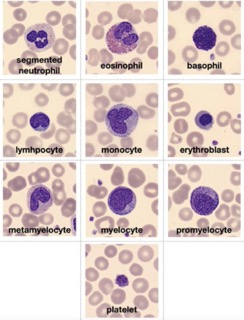

## Benchmarks
(2)
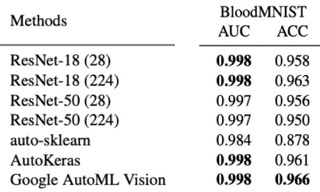

## Drawbacks of Current Research

One of the primary concerns associated with machine learning algorithms is the amount of time required for their execution due to the large quantities of data necessary for high accuracy. Training time on compressed images is less demanding than high definition images, but this choice of input data also has potential implications in the resulting model. A major challenge for critical systems implemented in medicine is that the use of convolutional neural networks in algorithms is innately invoking a "black box" method, making it functionally impossible for individuals to understand how the model arrives at particular decisions. This potentially results in incorrect interpretation of underlying issues, such as algorithms often considering noise that may not be useful in medical diagnosis as central learned features from the dataset. These issues are nearly ubiquitous in modern machine learning but inherit a new level of importance when applied to potentially life-saving applications. Moreover, there has been a lack of research on the development of algorithms with the capability to work on small amounts of data, which is more realistic for medical applications. We intend to test performance of our method on small subsets of the available dataset to simulate a data-sparse environment.

## Our Research Project

Our goal is the implement Geometric Machine Learning to ensure the developement of a more interpretable Machine Learning method that requires less data while having comparable results to the CNNs trained with copious amounts of data. Our hope is that by procesing images into curves we reduce the noise and input complexity. When dealing with the notions of distance in the algorithms we want to motivate a replacement of the standard Euclidian distance with the notion of distance in a SRV Quotient Space. Geomstats provides a convenient platform to make this ambition possible.

## Citations

1. Acevedo, A. et al. A dataset for microscopic peripheral blood cell images for development of automatic recognition
systems, https://doi.org/10.17632/snkd93bnjr.1 (2020).

2. Yang, J., Shi, R., Wei, D. et al. MedMNIST v2 - A large-scale lightweight benchmark for 2D and 3D biomedical image classification. Sci Data 10, 41 (2023). https://doi.org/10.1038/s41597-022-01721-8

# Visualization Code

We first import needed libraries.

In [1]:
#Import numpy.
import numpy as np

#Import matplotlib for visualization.
import matplotlib.pyplot as plt

#Import utility 
from skimage import util 
from skimage import feature
from skimage.measure import label   

We import our dataset and view a random image.

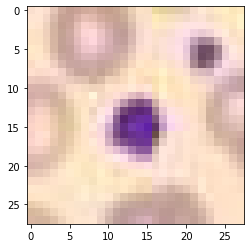

In [2]:
#Import blood dataset from MedMNIST.
#This assumes a shared directory; change as needed.
blood = np.load('bloodmnist.npz')

#Access only training images.
imgs = blood["train_images"]

#Pick one image to visualize to ensure a correct import.
img = imgs[0]
plt.imshow(img)
plt.show()

We develop utility methods needed to process these images. These methods find connected curves of contours, process images into their respective largest connected contour, and order the resulting contour so that we may eventually process into curves.

In [3]:
#Find the largest connected curve and erase any other extra curves.
def findLargestConnectedCurve(img):
    
    #Label each connected component with a different number.
    labelled = label(img)
    
    #Store number of occurances of each label.
    counts = [0] * (np.amax(labelled) + 1)
    
    #Count occurances of each label.
    for i in range(len(img)):
        for j in range(len(img)):
            counts[labelled[i][j]] += 1
    
    #We ignore 0, as this is background.
    counts[0] = 0
    
    #Get the index of the highest.
    highest = np.argmax(counts)
    
    #Return image with only these labels nonzero.
    connectedCurve = (labelled == highest)

    #Return result.    
    return connectedCurve



#Make a contour by using the above.
def makeContour(img, thresholdVal, sigmaVal):    
    
    #First, we convert to grayscale.
    grayimg = np.dot(img, [.3, .6, .1])

    #Then we invert because contours are drawn around lightest image parts,
    # while grayscale will have our area of interest be darkest.
    inv_gray_img = util.invert(grayimg)
    
    #We now threshold by the passed value.
    thresh = thresholdVal
    binaryImg = inv_gray_img > thresh
    
    #Canny edge detect to get contour.
    pic = feature.canny(binaryImg, sigma=sigmaVal)
    
    #Remove superfluous curves and return.
    return findLargestConnectedCurve(pic)



#Convert a 2D matrix into ordered curve form.
def orderedCurve(img, n):
    
    #Input: 2D matrix of 0s and 1s (off vs on curve), n = square size of image
    #Output: Ordered array of 2d coordinates of curve points
    
    #First, pick start point. 
    
    #We scan all pixels with value True into an array for easy access.
    pixelList = []
    for row in range(n):
        for col in range(n):
            if img[row][col]:
                pixelList.append([row, col])
                
    #Now pixelList is full. Pick a starting pixel.
    #We will pick any "ends" of the curve if they are present, and randomly if closed.
    out = []
    
    for pixel in pixelList:
        
        #Count number of neighbors.
        neighborCount = 0
        
        #Get coordinates.
        x = pixel[0]
        y = pixel[1]
        
        #Examine each neighbor.
        for neighbor in [[x,y-1], [x,y+1], [x-1,y], [x+1,y], [x-1,y-1], [x+1,y-1], [x-1,y+1], [x+1,y+1]]:
            r = neighbor[0]
            c = neighbor[1]
            if (0 <= r and r <= n) and (0 <= c and c <= n) and img[r][c]:
                #This neighbor is in the curve.
                neighborCount += 1
    
        #Test whether this is an open end.
        if neighborCount < 2:
            out.append(pixel)
            break
    
    #Handle edge case.
    if len(out) == 0:
        #The curve is truly closed. Choose randomly.    
        out = [pixelList[0]]    
    
    #Scan neighbors, first cordinal directions, then diagonals.
    #We choose the next pixel to append to our ordered output.
    while len(out) < len(pixelList):
        
        #Get most recent pixel.
        currentPixel = out[-1]
        x = currentPixel[0]
        y = currentPixel[1]
        
        #Store its neighbors.
        nbors = []
        
        #Look for valid unvisited neighbors.
        for neighbor in [[x,y-1], [x,y+1], [x-1,y], [x+1,y], [x-1,y-1], [x+1,y-1], [x-1,y+1], [x+1,y+1]]:
            r = neighbor[0]
            c = neighbor[1]
            if ((0 <= r and r <= n) and (0 <= c and c <= n)) and (img[r][c] and not neighbor in out):
                #This neighbor is in the curve.
                nbors.append(neighbor)
                
        #If we succeed, add to the list. 
        if len(nbors) > 0:
            out.append(nbors[0])
        else:
            
            #We're at a dead end. Jump to nearest pixel.            
            options = []
            dists = []
            for pixel in pixelList:
                if not (pixel in out) and (pixel[0] != x or pixel[1] != y):
                    options.append(pixel)
                    dists.append(abs(pixel[0] - x) + abs(pixel[1] - y))
                    
            #Get nearest pixel.
            minDist = min(dists)
            index = dists.index(minDist)
            
            #Choose the minimum index.
            out.append(options[index])

    #Out should be, roughly, an ordered list of pixels along the curve.
    return out

Here we showcase our basic visualization ideas on a small slice of the original dataset.

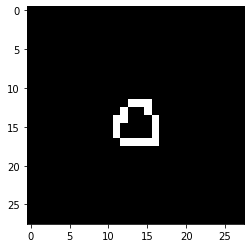

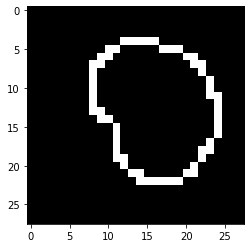

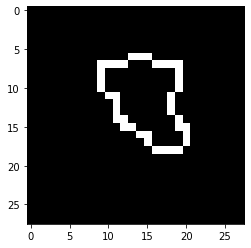

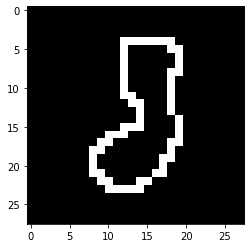

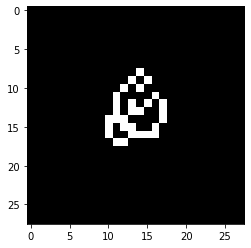

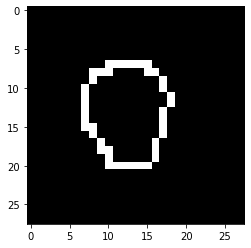

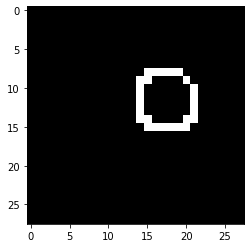

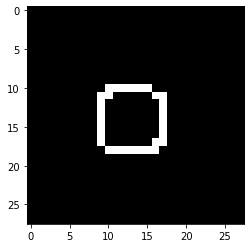

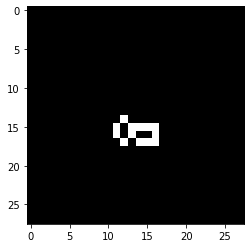

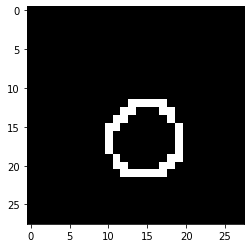

In [4]:
#We now test the above through visualizing some image contours.
testList = imgs[:10]

for img in testList:
    
    #Make contour for hand-tuned parameters.
    contour = makeContour(img, -100, 0.5)
    plt.imshow(contour, cmap=plt.cm.gray)
    plt.show()

Now we move toward creating a curve. We first create a dictionary to ensure visualizations can be associated with their respective class labels.

In [5]:
#We create a dictionary to match cell names to data labels.
cell_names = {
    0 : 'basophils',
    1 : 'eosinophils',
    2 : 'erthroblasts',
    3 : 'immature granulocytes',
    4 : 'lymphocytes',
    5 : 'monocytes',
    6 : 'neutrophils',
    7 : 'platelets (thrombocytes)'
}

#Some test indices of cell images with corresponding type for visualization.   
indices = [26, 10, 6, 1, 28, 22, 2, 0]

We develop a quick cell visualization method.

In [6]:
#We make a method to plot our ordered list of pixels.
#Note that this does not use geomstats - we must work out
#bugs in our porting before these objects behave how they should.
def _plot_cell_type(cell_index, cell_type):
    
    #Make contour.
    contour = makeContour(imgs[cell_index], -100, 0.5)
    
    #Change contour into ordered points for geomstats curve object.
    path_coordinates = np.transpose(orderedCurve(contour, 28))
    
    #Plot the resulting coordinates.
    plt.plot(path_coordinates[0,:], path_coordinates[1,:], 'o-r')
    plt.title(cell_names[cell_type])
    plt.show()

Finally, we visualize our results.

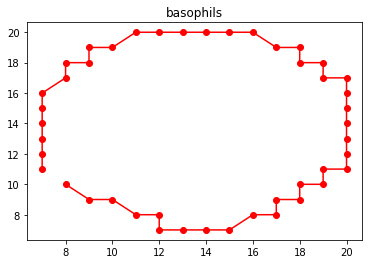

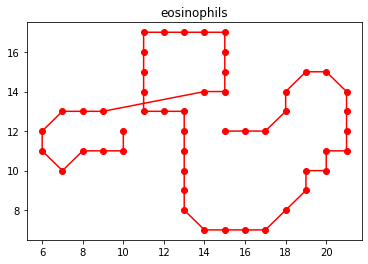

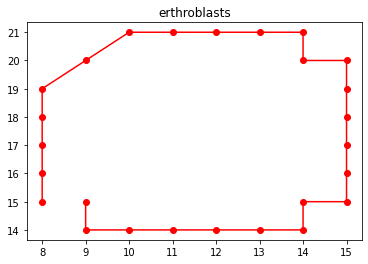

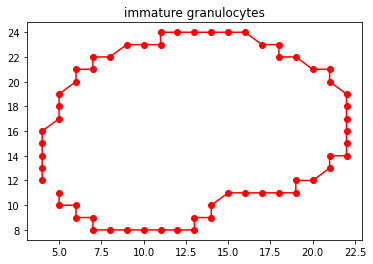

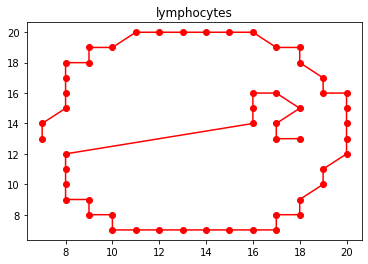

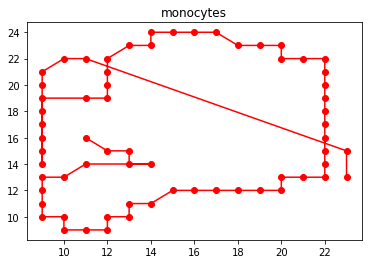

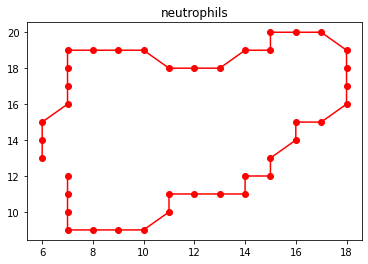

In [7]:
#Visualize one cell of each type.
for i in range(7):
    _plot_cell_type(indices[i], i)

We note that some of these results are fairly lackluster. The problem of image processing with some of the most complicated cell shapes where the automatic contouring methods do not have satisfactory performance is quite hard. Our next step in this project is to have a two-pronged approach of both improving the basic processing and screening out the worst failures of the data, and converting the given objects into proper geomstats curves, a step that has caused some errors and that we must resolve in order to learn on these objects in the future. We have much work to do, and look forward to implementing these improvements. 